#Setup#

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## CD TO RIGHT DIRECTORY
# Add a shortcut to the 'DL Project' to your My Drive folder
%cd "/content/drive/My Drive/DL Project"

/content/drive/My Drive/DL Project


In [5]:
ls 'code/data/oversampled_data'

Albrecht_Dürer/  Frida_Kahlo/      Leonardo_da_Vinci/  Peter_Paul_Rubens/      Rembrandt/
Andy_Warhol/     Gustav_Klimt/     Michelangelo/       Pierre-Auguste_Renoir/  Salvador_Dali/
Caravaggio/      Jackson_Pollock/  Pablo_Picasso/      Piet_Mondrian/          Sandro_Botticelli/
Claude_Monet/    Jan_van_Eyck/     Paul_Gauguin/       Raphael/                Vincent_van_Gogh/


#Experiment Functions#

In [6]:
def run_experiment(directory, lr):
  data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # Reserve 20% of the images for testing
  )

  train_generator = data_gen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
  )

  test_generator = data_gen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
  )

  # Load MobileNetV2 model pre-trained on ImageNet
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  # Freeze the layers of the base model
  for layer in base_model.layers:
      layer.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(3, activation='relu')(x)  # Adding a dense layer
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer with softmax

  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
  )

  loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
  print(f'Test loss: {loss}')
  print(f'Test accuracy: {accuracy}')
  return loss, accuracy, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'], model

In [7]:
def plot_graphs(loss_df, val_loss_df, acc_df, val_acc_df, title):
  fig, axs = plt.subplots(2, 1, figsize=(10, 10))

  axs[0].plot(loss_df, label='Training Loss')
  axs[0].plot(val_loss_df, label='Validation Loss')
  axs[0].set_title('Training & Validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  axs[1].plot(acc_df, label='Training Accuracy')
  axs[1].plot(val_acc_df, label='Validation Accuracy')
  axs[1].set_title('Training & Validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.tight_layout()
  #'learning_curves.png'
  plt.savefig(title)
  plt.show()

#Sample Experiment#

In [ ]:
loss, accuracy, loss_df, val_loss_df, acc_df, val_acc_df = run_experiment('code/data/sample', 0.01)

Found 526 images belonging to 3 classes.
Found 129 images belonging to 3 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
 9/16 [===============>..............] - ETA: 2:06 - loss: 0.8274 - accuracy: 0.6037

In [ ]:
plot_graphs(loss_df, val_loss_df, acc_df, val_acc_df)

NameError: name 'loss_df' is not defined

#Experiment 1.1 Original, 0.001#

In [ ]:
loss_exp_1_1, accuracy_exp_1_1, loss_df_exp_1_1, val_loss_df_exp_1_1, acc_df_exp_1_1, val_acc_df_exp_1_1 = run_experiment('code/data/original_data', 0.001)

Found 3236 images belonging to 20 classes.
Found 797 images belonging to 20 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
101/101 [==============================] - 1846s 18s/step - loss: 2.8416 - accuracy: 0.1957 - val_loss: 2.7209 - val_accuracy: 0.2422
Epoch 2/10
101/101 [==============================] - 37s 367ms/step - loss: 2.5363 - accuracy: 0.2821 - val_loss: 2.5374 - val_accuracy: 0.2839
Epoch 3/10
101/101 [==============================] - 37s 369ms/step - loss: 2.3511 - accuracy: 0.3087 - val_loss: 2.4393 - val_accuracy: 0.2812
Epoch 4/10
101/101 [==============================] - 35s 345ms/step - loss: 2.2625 - accuracy: 0.3149 - val_loss: 2.3631 - val_accuracy: 0.2721
Epoch 5/10
101/101 [==============================] - 33s 328ms/step - loss: 2.1621 - accuracy: 0.3205 - val_loss: 2.2934 - val_accuracy: 0.2878
Epoch 6/10
101/101 [==============================] - 33s 328ms/step - loss: 2.0290 - accuracy: 0.3493 - val_loss: 2.1705 - val

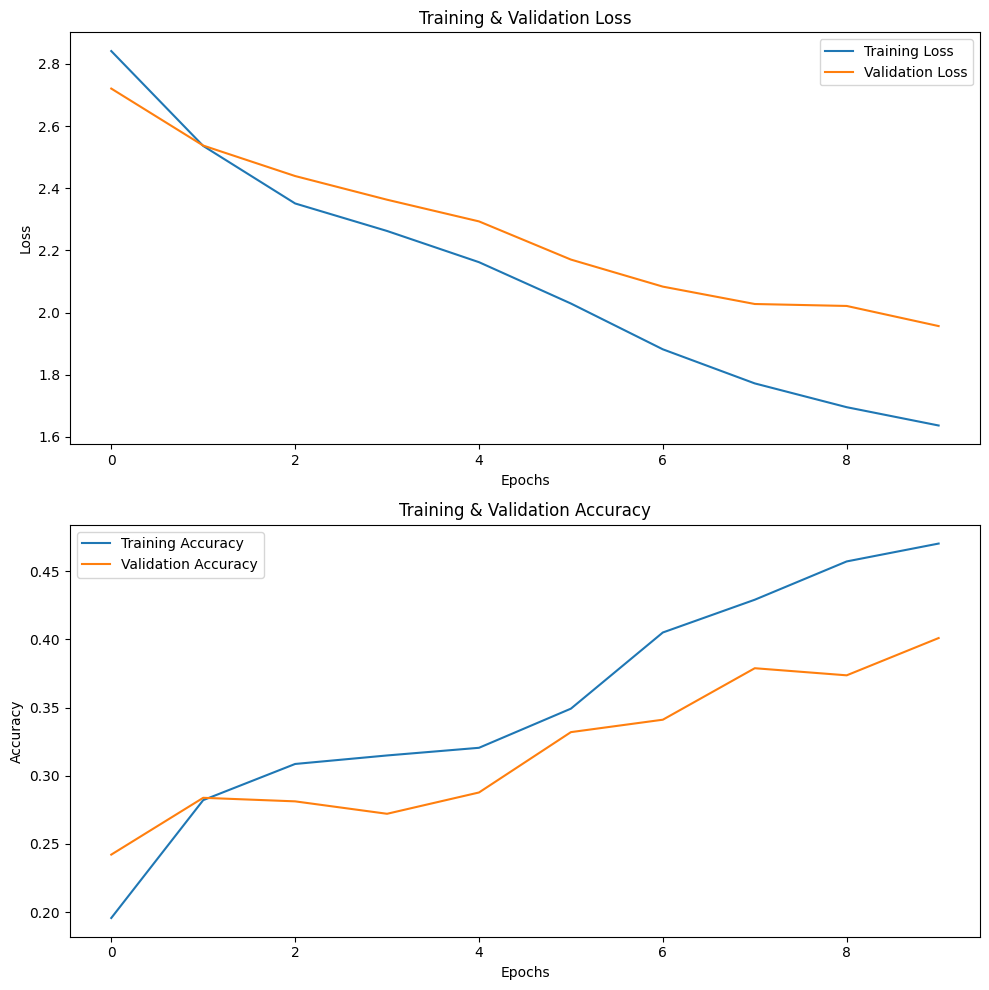

In [ ]:
plot_graphs(loss_df_exp_1_1, val_loss_df_exp_1_1, acc_df_exp_1_1, val_acc_df_exp_1_1)

#Experiemnt 2.1 Augmented Data#

In [ ]:
loss_exp_2_1, accuracy_exp_2_1, loss_df_exp_2_1, val_loss_df_exp_2_1, acc_df_exp_2_1, val_acc_df_exp_2_1, model_2_1 = run_experiment('code/data/augmented_data', 0.001)

Found 10034 images belonging to 20 classes.
Found 2498 images belonging to 20 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
313/313 [==============================] - 3897s 12s/step - loss: 2.7345 - accuracy: 0.1572 - val_loss: 2.5780 - val_accuracy: 0.2296
Epoch 2/10
313/313 [==============================] - 649s 2s/step - loss: 2.3811 - accuracy: 0.2680 - val_loss: 2.3541 - val_accuracy: 0.2756
Epoch 3/10
313/313 [==============================] - 616s 2s/step - loss: 2.1293 - accuracy: 0.3458 - val_loss: 2.1395 - val_accuracy: 0.3321
Epoch 4/10
313/313 [==============================] - 644s 2s/step - loss: 1.9277 - accuracy: 0.3948 - val_loss: 2.0249 - val_accuracy: 0.3690
Epoch 5/10
313/313 [==============================] - 631s 2s/step - loss: 1.8034 - accuracy: 0.4182 - val_loss: 1.9695 - val_accuracy: 0.3786
Epoch 6/10
313/313 [==============================] - 653s 2s/step - loss: 1.7144 - accuracy: 0.4404 - val_loss: 1.9218 - val_accurac

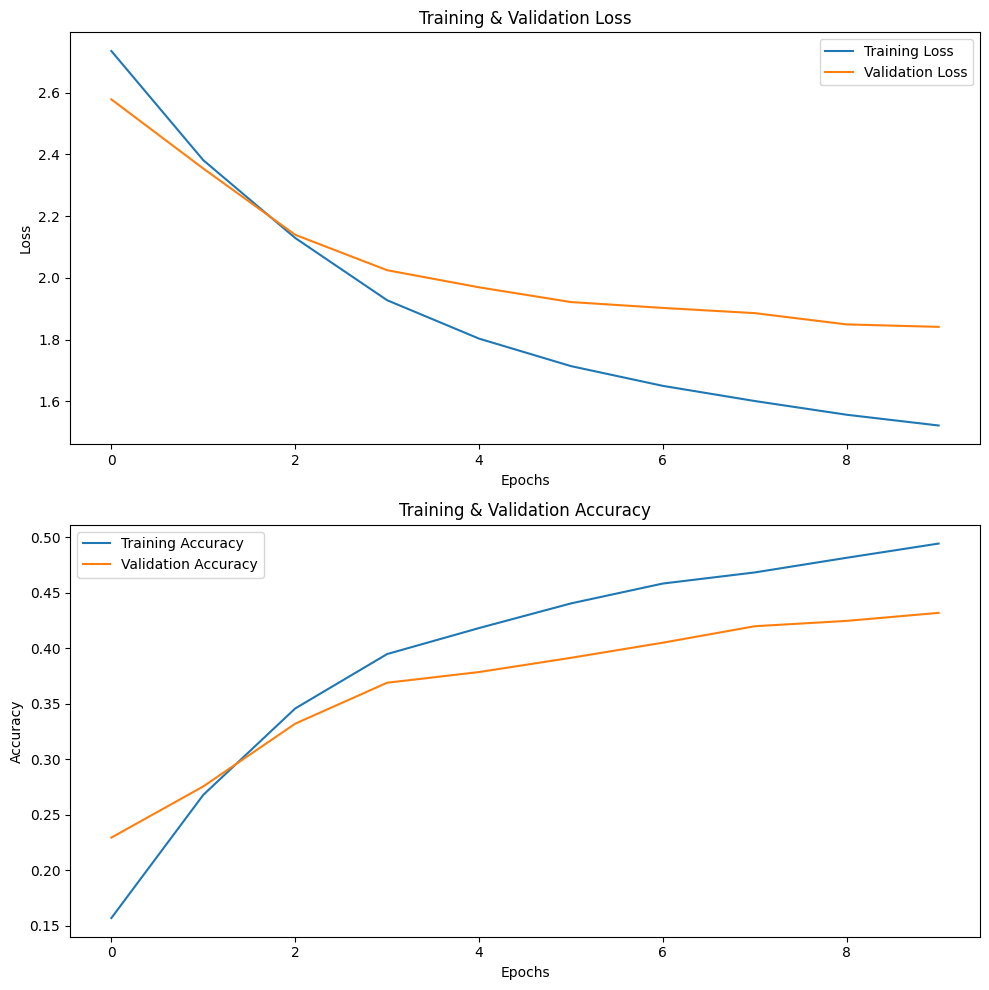

In [ ]:
plot_graphs(loss_df_exp_2_1, val_loss_df_exp_2_1, acc_df_exp_2_1, val_acc_df_exp_2_1, "learning_curves_2_1.png")

In [10]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
  )

next_sample = data_gen.flow_from_directory(
    'code/data/augmented_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
  )

Found 1246 images belonging to 20 classes.


In [ ]:
loss, accuracy = model_2_1.evaluate(next_sample, steps=next_sample.samples // next_sample.batch_size)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

38/38 [==============================] - 66s 2s/step - loss: 1.7714 - accuracy: 0.4359
Test loss: 1.7713940143585205
Test accuracy: 0.43585526943206787


#Experiment 3.1 Oversampled Data#

In [8]:
loss_exp_3_1, accuracy_exp_3_1, loss_df_exp_3_1, val_loss_df_exp_3_1, acc_df_exp_3_1, val_acc_df_exp_3_1, model_3_1 = run_experiment('code/data/oversampled_data', 0.001)

Found 4294 images belonging to 20 classes.
Found 1066 images belonging to 20 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
134/134 [==============================] - 2101s 16s/step - loss: 2.7150 - accuracy: 0.1917 - val_loss: 2.5702 - val_accuracy: 0.2509
Epoch 2/10
134/134 [==============================] - 29s 219ms/step - loss: 2.3622 - accuracy: 0.2773 - val_loss: 2.3731 - val_accuracy: 0.2708
Epoch 3/10
134/134 [==============================] - 30s 222ms/step - loss: 2.1718 - accuracy: 0.3013 - val_loss: 2.2475 - val_accuracy: 0.3068
Epoch 4/10
134/134 [==============================] - 30s 220ms/step - loss: 2.0361 - accuracy: 0.3353 - val_loss: 2.1529 - val_accuracy: 0.3116
Epoch 5/10
134/134 [==============================] - 29s 220ms/step - loss: 1.9406 - accuracy: 0.3566 - val_loss: 2.0785 - val_accuracy: 0.3456
Epoch 6/10
134/134 [==============================] - 29s 219ms/step - loss: 1.8611 - accuracy: 0.3726 - val_loss: 2.0221 - va

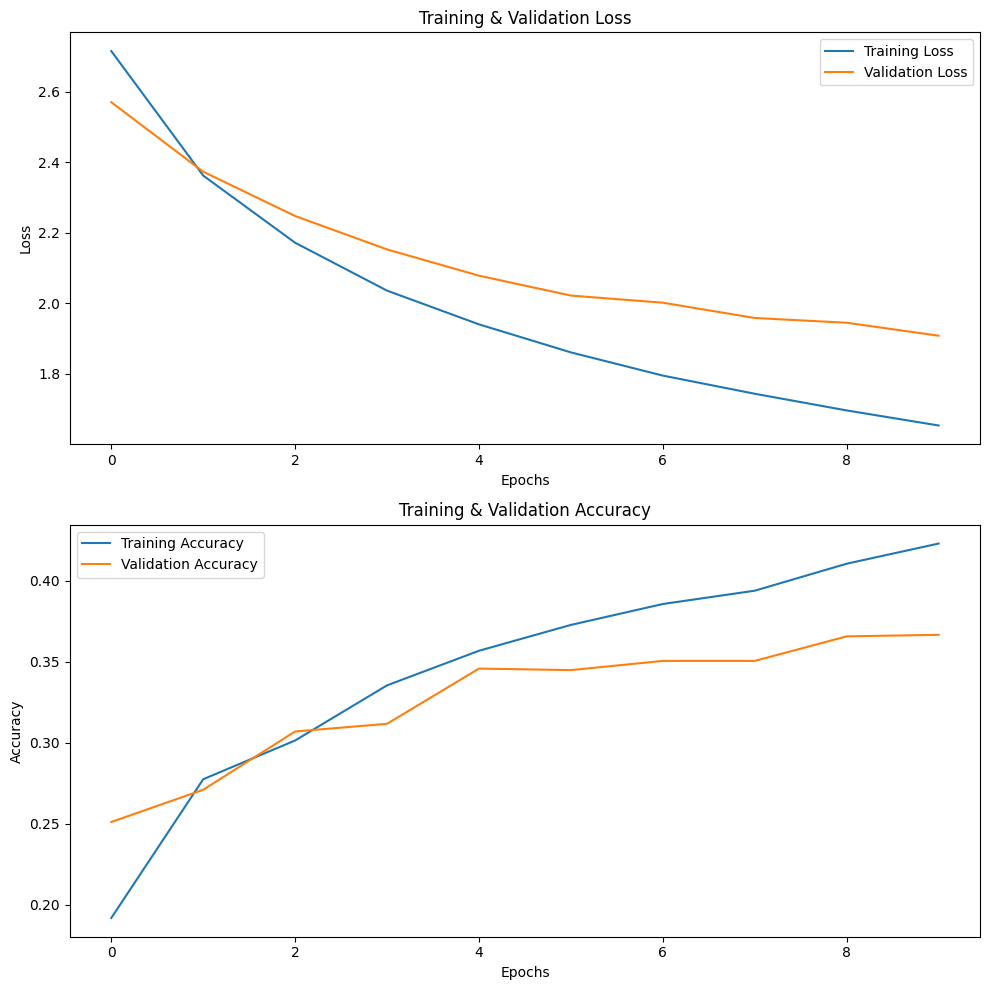

In [9]:
plot_graphs(loss_df_exp_3_1, val_loss_df_exp_3_1, acc_df_exp_3_1, val_acc_df_exp_3_1, "learning_curves_3_1.png")